# Arc Characteristics Model for TIG Welding
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mateotournoud/acm4tw.git/main?urlpath=%2Fdoc%2Ftree%2FArc+Characteristics+Model+for+TIG+Welding.ipynb)

*By Mateo Tournoud.*


## Introduction

This Jupyter Notebook offers the possibility to simulate various plasma properties of TIG welding using relatively simple algebraic expressions, following the workflow proposed by Delgado-Álvarez et al. (2021) [[1](#ref-1)] for monoatomic gases. These expressions are based on dimensional analysis, with unknown coefficients fitted to the results of both a highly detailed physical model and experimental data. They can be used to calculate the **Arc Shape**, the **Arc Column Characteristics** and the **Arc–Weld Pool Interactions** of a TIG welding process for a given current intensity, arc length, and gas composition.

This Jupyter Notebook and its modules do not need to be downloaded or installed. By clicking the **Launch Binder** button, the notebook is run in a virtual environment, facilitating the process and ensuring reproducibility.

All steps are implemented using the `acm4tw` module, written in Python 3.11.9. A brief explanation of the algorithms used, their limitations, and the interpretation of the results is provided in each section. All equations and coefficients used in the model are taken from [[1](#ref-1)].

## Prerequisites

### Boundary Conditions

The user must define the **Boundary Conditions** that the model will adopt to compute the arc characteristics. Here are included:
- Gas Name: the elemental composition of the shielding gas. It must be provided as `Argon` for the 100% Ar intert shielding, `Helium` for the 100% He, or `Argon/Helium` for their 50/50 mixture.
- Current: the current intensity of the TIG welding process, provided in amperes (A).
- Arc Length: the distance between the cathode, which is assumed to be flat rather than an electrode with a realistic geometry, and the anode, corresponding to the weld pool surface. At this stage, the arc length must be provided in millimeters (mm) to ensure correctness; the code will later convert this value into meters (m).
- Validity ranges: this is a boolean variable (i.e., can be True or False) and if it is activated, the plots only show arc characteristics calculated at the specified validity ranges for each equation. These validity ranges can also be visualized at the `table2.csv`, `table4.csv` and `table5.csv` tables shown in the section *Import the coefficients*.

As a recommendation, Delgado-Álvarez et al. (2021) [[1](#ref-1)] specify that "typical operating parameters were selected with currents ranging from 200 to 300 A and arc lengths between 5 and 10 mm".

> This is **the only section** that shall be manually modified by the user with own boundary conditions along all this Jupyter Notebook.

In [40]:
gas_name = "Argon" # Argon, Helium, Argon/Helium
current = 200 # A
arclength = 8 # mm
valid_arc_shape = True # True/False
valid_arc_column = False # True/False

### Import the libraries

The required Python libraries to run this Jupyter Notebook are `numpy` and `pandas`. Both are used to create the structure of the data and process it.

In addition, the previously mentioned `acm4tw` module includes all the equations presented in [[1](#ref-1)] and makes use of them. It is provided together with two additional plotting libraries, `plotlib` and `pseudocolor`, which were developed to display the simulation results and are written in Python 3.11.9.

Finally, the `processing` module is also imported. It contains code that processes the equations defined in `acm4tw`, but it does not introduce additional information into this notebook.

In [41]:
import pandas as pd
import numpy as np
import acm4tw
import plotlib
import pseudocolor
import processing

### Import the coefficients

All the parameters to be used are given in the CSV files `table4.csv`, `table5.csv` and `table2.csv`. The first one is the **Table 4** [[1](#ref-1)], where the Prandtl number for each gas composition can be found: Argon, Helium, or Argon/Helium.

The Prandtl number compares **momentum diffusion** to **thermal diffusion** and can be defined as:

$$
Pr = \frac{ν}{α} = \frac{μc_p}{k}
$$

where:
- $ν$ = kinematic viscosity (momentum diffusivity)
- $α$ = thermal diffusivity
- $μ$ = dynamic viscosity
- $c_p$ = specific heat at constant pressure
- $k$ = thermal conductivity.

The second CSV file contains the **Table 5** [[1](#ref-1)], with all the ranges of validity for each equation, R*2 values and coefficients for the equations used by the `acm4tw` module. The last one is the **Table 2** [[2](#ref-2)], similar to the Table 5, but with the coefficients used in the equation of the Profile Temperature for 100% Argon and at the calculation of the Shear Stress.

From the `table4.csv` file, the only values used are the Prandtl Numbers, given as constants for each gas composition, while from the `table2.csv` and `table5.csv` the ranges and the R*2 values are not implemented in the calculation. 

> ##### Model limitation
> The shear stress cannot be calculated for the welding with a 100% of He nor the combination of 50% Ar and 50% He, because the constants of the **Table 2** [[2](#ref-2)] are only available for pure Argon.

In [42]:
table2 = pd.read_csv('table2.csv', sep=',')
table2 = table2.fillna("")
table2

,gas,equation,range,R**2,a,b,c,d,e,f,g,h,i,j
0,ar,T_over_Tmaxo_Ar,"['R/Ra',0.0,1.5]",0.996,1.007,-1.345,1.101,1.147,-2.939,2.231,-0.839,0.168,-0.017,0.00065
1,ar,local_max_at_Z__T_Ar1,"['Z/L',0,0.3]",0.975,0.553,0.451,0.157,19.032,67.229,84.301,37.0,,,
2,ar,local_max_at_Z__T_Ar2,"['Z/L',0.3,inf]",0.981,120500.000,42110.000,1163.000,132400.0,10.138,115300.0,0.035,35830.0,,
3,all,S_over_Smax,,0.981,0.222,-0.211,-0.039,0.887,0.346,,,,,
4,ar,interaction_max__S,,0.975,-39.160,0.823,-5679.000,,,,,,,


In [43]:
table4 = pd.read_csv('table4.csv', sep=',')
table4

,gas,prandtlnr
0,ar,0.5863
1,he,1.1995
2,ar/he,0.6196


In [44]:
table5 = pd.read_csv('table5.csv', sep=',')
table5 = table5.fillna("")
table5

,gas,equation,range,R**2,a,b,c,d,e,f,g,h
0,all,Ra_from_Z,"['Z/Rc',0.5,5.0]",0.976,2.504700e+00,-2.721400e+00,,,,,,
1,all,Btheta_over_Bmaxo,,0.967,7.290000e-02,2.069000e-01,-0.0165,-1.6238,0.8898,,,
2,all,T_over_Tmaxo,"['R/(Ra*Pr)',0.0,1.0]",0.942,1.001700e+00,2.700000e-03,-0.3967,0.0508,-0.8219,1.4013,-0.5988,
3,all,Vz_over_Vmaxo,,0.980,9.802000e-01,-4.537000e-01,0.0503,-0.5459,4.7656,,,
4,ar,local_max_at_Z__B,"['Z/L',0.4,0.8]",0.985,-1.975000e+01,-1.710000e-02,141.2,-485.6,352.0,-2.0,,
5,he,local_max_at_Z__B,"['Z/L',0.4,0.8]",0.975,-2.900000e-01,-1.420000e-04,30.3,-11.009,0.91,2.0,,
6,ar/he,local_max_at_Z__B,"['Z/L',0.4,0.8]",0.984,2.507000e+00,-1.460000e-03,-18.09,58.21,-1.27,-5.77,,
7,ar,local_max_at_Z__T,"['Z/L',0.3,0.8]",0.956,1.245000e+02,1.153000e-01,-182.3,-4026.5,-0.00001,2.0,,
8,he,local_max_at_Z__T,"['Z/L',0.3,0.8]",0.977,7.710000e+01,2.550000e-02,239.8,-917.7,0.00295,2.0,,
9,ar/he,local_max_at_Z__T,"['Z/L',0.3,0.8]",0.973,-5.192000e+08,6.464000e+08,2000000000.0,-2680000000000.0,39460000.0,0.5,,


### Gas nomenclature, Prandtl Number and definition of the coordinates

The gas nomenclature will allow the extraction of the correct coefficients from Tables 4 and 5 to work with each equation. The Prandtl number is assumed to be a constant that depends on the elemental composition, and it is taken directly from Table 4.

The axial axis  $(Z)$ is defined as a discrete variable of one hundred values extending from $Z_0 = 0\text{ mm}$, which is the position at the cathode, to $Z_1 = L$ at the anode, using the function  `numpy.linspace`. $L$ is the negative value of the arc length, provided by the user at the boundary conditions.

The radial axis $(R)$ is defined similarly, but in this case, it contains two hundred values, starting at $R_0 = 0\,mm$ at the symmetry axis, until $R_1 = 10\,mm$, considered a large enough value for such model. The interactions between the axial and the radial axis form the **coordinates system**. 

Additionally, the arc length is converted from milimeters to meters. The reason for not inserting the arc length in meters since the beginning is to ensure that this value is provided correctly.

In [45]:
arclength = arclength/1000 # convert to m and place the 0 at the cathode
gascomp = {"Argon": "ar", "Helium":"he", "Argon/Helium":"ar/he"}
Pr_number = table4.loc[table4["gas"] == gascomp[gas_name], "prandtlnr"].iloc[0]
Zcoord = np.linspace(0,-arclength,101)

## Calculate the Cathode Radius (Rc)

The Cathode Radius Rc is the radius of the circular spot at the cathode, where the current density is assumed to be a parabolic radial profile with an average value, Jc, of $6.5 × 10^7 A/m^2$ [[1](#ref-1)]. The cathode radius Rc is computed in the `acm4tw` module as:

$$
R_c = \left( \frac{I}{\pi J_c} \right)^{0.5}
$$

In [46]:
Rc = acm4tw.Rc_from_I(current)
print(f"Rc = {(Rc*1000):.4f} mm")

Rc = 0.9897 mm


## Universal shape of the arc

The universal shape of the arc for monoatomic gases and their mixtures can be obtained in terms of the arc radius (Ra), defined for the Argon as the radius of the arc boundary that coincides with the loci formed by the 10,000 K isotherm. This temperature was chosen since the corresponding electric conductivity of Ar is enough (≈ 2850 S*m−1) to maintain current flow [[1](#ref-1)]. 

The arc is shaped in the `acm4tw` module by calculating the arc radius (*Ra*) as a function of the axial coordiantes (*Z*) 

$$
Ra(Z) = \frac{Rc}{Pr^{\mathrm{0.85}}}
\cdot \ln\!\left(
a + \frac{b \, Z \, Pr^{\mathrm{0.85}}}{Rc}
\right)
$$

where *Pr* is the Prandtl Number, *Rc* is the Cathode Radius calculated previously and *a* and *b* are coefficients that come from the **Table 5** [[1](#ref-1)]. The validity range of this equation is at $0.5 ≤ Z/Rc ≤ 5.0$.

The reason for not using a dimensionless representation is that this Jupyter Notebook is intended to calculate the characteristics of a TIG welding process with its specific set of parameters.

Once the arc radius is calculated, the shape of the arc can be plotted using the `plotlib` module.

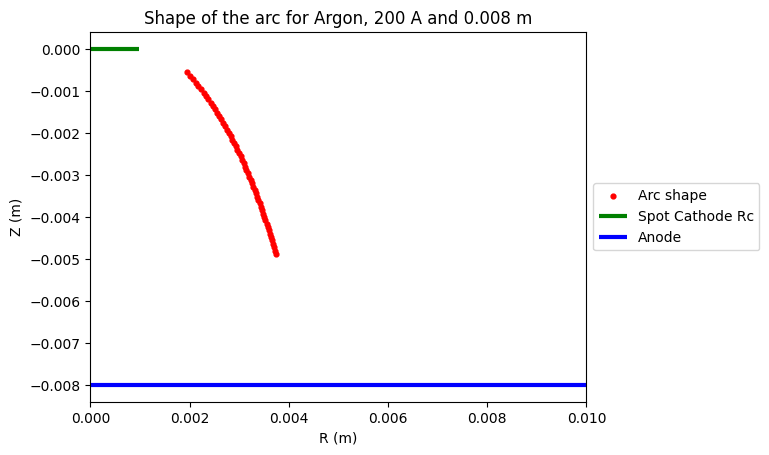

In [47]:
# Select the coefficients a and b
row11 = table5.loc[table5["equation"] == "Ra_from_Z"].iloc[0]
a11, b11 = row11["a"], row11["b"]

# Calculate Ra
Ra = acm4tw.Ra_from_Z(Zcoord,Rc,Pr_number,a11,b11)

# Filter Ra for valid range
if valid_arc_shape:
    Ra_filtered = Zcoord*(-1)/Rc
    mask = (Ra_filtered < 0.5) | (Ra_filtered > 5.0)
    Ra_filtered = np.where(mask, np.nan, Ra)
else:
    Ra_filtered = Ra

# Plot Ra
plotlib.shape_of_the_arc(Ra_filtered,Zcoord,Rc,arclength,gas_name,current)

As in Delgado-Álvarez et. al. (2021) [[1](#ref-1)], It must be mentioned that the universal shape of the arc is valid in the arc column but not in the region where the jet impinges on the anode and deforms the arc shape to create the well-known bell-like shape. The shape is also not valid in the cathode attachment region, also known as the cathode fall.

## Arc column characteristics

The arc column characteristics are those that have their domain along all the arc column, from the cathode spot until the anode surface. They are:
- Magnetic Field Bθ (T)
- Temperature T (K)
- Axial Velocity Vz (m/s)

### Computing the arc column characteristics

In the `acm4tw` module, the magnetic field and the axial velocity are computed with the equation 3 and 5 [[1](#ref-1)] respectively, for all gas compositions:

$$
\frac{B_\Theta}{B_{\max}^\circ}\,\left(R,R_a(Z)\right) = \frac{
a + b\left(\frac{R}{R_a}\mathrm{Pr}^{-0.5}\right)^{0.5}
+ c\left(\frac{R}{R_a}\mathrm{Pr}^{-0.5}\right)}
{1 + d\left(\frac{R}{R_a}\mathrm{Pr}^{-0.5}\right)^{0.5}
+ e\left(\frac{R}{R_a}\mathrm{Pr}^{-0.5}\right)}
$$

$$
\frac{V_z}{V_{\max}^\circ}\,\left(R,R_a(Z)\right)=\frac{ a
+ b\left(\frac{R}{R_a}\mathrm{Pr}^{-1}\right)
+ c\left(\frac{R}{R_a}\mathrm{Pr}^{-1}\right)^2}
{1 + d\left(\frac{R}{R_a}\mathrm{Pr}^{-1}\right)
+ e\left(\frac{R}{R_a}\mathrm{Pr}^{-1}\right)^2}
$$

When the gas composition is 100% of Helium or 50% Ar with 50% He, the temperature is computed with the equation 4 [[1](#ref-1)]:

$$
\frac{T}{T_{\max}^\circ}\,\left(R,R_a(Z)\right)=a
+ b\left(\frac{R}{R_a}\mathrm{Pr}^{-1}\right)
+ c\left(\frac{R}{R_a}\mathrm{Pr}^{-1}\right)^2
+ d\left(\frac{R}{R_a}\mathrm{Pr}^{-1}\right)^3
+ e\left(\frac{R}{R_a}\mathrm{Pr}^{-1}\right)^4
+ f\left(\frac{R}{R_a}\mathrm{Pr}^{-1}\right)^5
+ g\left(\frac{R}{R_a}\mathrm{Pr}^{-1}\right)^6
$$

Where $B_{max}°$, $T_{max}°$ and $V_{max}°$ are the local maxima for each arc column characteristic at each Z position, and *a*, *b*, *c*, *d*, *e*, *f* and *g* are the coefficients extracted from the **Table 5** [[1](#ref-1)]. Each local maxima can be computed as a function of the axial position $Z$ by:

$$
\boxed{{Physical\ quantity}_{max}^\circ(Z) = a + bI + cL + dZ + (e \cdot {Physical\ quantity}_{max})^f}
$$

where $I$ is the current intensity, $L$ is the arc length and ${Physical\ quantity}_{max}$ is the global maxima for that property along all the arc column, computed as:

$$
\boxed{{Physical\ quantity}_{max} = a+bI+cL}
$$

The equation 4 [[1](#ref-1)] could also be used to simulate the temperature of the arc when the gas composition is 100% of Argon. However, when doing this, the 10,000 K isotherm and the curve of the shape of the arc don't match. For that reason, when the shielding gas is 100% of Argon, the temperature is computed with the equation 4 [[2](#ref-2)] with its validity range at $R/R_a ≤ 1.5$:

$$
\frac{T}{T_{\max}^\circ}\,\left(R,R_a(Z)\right)=a
+ b\left(\frac{R}{R_a}\right)^2 + c\left(\frac{R}{R_a}\right)^4
+ d\left(\frac{R}{R_a}\right)^6 + e\left(\frac{R}{R_a}\right)^8
+ f\left(\frac{R}{R_a}\right)^{10} + g\left(\frac{R}{R_a}\right)^{12}
+ h\left(\frac{R}{R_a}\right)^{14} + i\left(\frac{R}{R_a}\right)^{16}
+ j\left(\frac{R}{R_a}\right)^{18}
$$

Where *a*, *b*, *c*, *d*, *e*, *f*, *g*, *h*, *i* and *j* are the coefficients extracted from the **Table 2** [[2](#ref-2)]. And the local maxima of the temperature at each axial position is given by the equation 7 [[2](#ref-2)] for $Z/L < 0.3$ or the equation 8 [[2](#ref-2)] for $Z/L ≥ 0.3$, respectively:

$$
T_{\max}^{\circ} = \left[a + b \left( \frac{z}{(R_c L)^{0.5}} \right)^{0.5}
- c \left( \frac{Z}{(R_c L)^{0.5}} \right)
+ d \left( \frac{Z}{(R_c L)^{0.5}} \right)^{1.5}
- e \left( \frac{Z}{(R_c L)^{0.5}} \right)^{2}
+ f \left( \frac{Z}{(R_c L)^{0.5}} \right)^{2.5}
- g \left( \frac{Z}{(R_c L)^{0.5}} \right)^{3}\right]\,*\, T_{\max}
$$

$$
T_{\max}^{\circ} = \left[a + b \ln\!\left( \frac{Z}{L} \right)
+ \frac{c}{\ln\!\left( \frac{Z}{L} \right)}
+ d \left( \ln\!\left( \frac{Z}{L} \right) \right)^2
+ \frac{e}{\left( \ln\!\left( \frac{Z}{L} \right) \right)^2}
+ f \left( \ln\!\left( \frac{Z}{L} \right) \right)^3
+ \frac{g}{\left( \ln\!\left( \frac{Z}{L} \right) \right)^3}
+ h \left( \ln\!\left( \frac{Z}{L} \right) \right)^4
\right]\,*\,\left(\frac{R_c^{0.5} \, I^{0.1}}{L^{0.2}}\right)
$$

The arc column characteristics are calculated in the submodule `processing`. The result is given as the `arc_column` dataframe below, together with their global maximum along the domain:

In [48]:
arc_column = processing.arc_column_characteristics(current, arclength, gas_name, Pr_number, Zcoord, Ra, Rc, table2, table5, valid_arc_column)

Global Maximum Magnetic Flux Density: Bmax = 0.0433192 T
Global Maximum Temperature: Tmax = 21812.344 K
Global Maximum Axial Arc Velocity: Vmax = 311.032 m/s


### Plotting

The absolute quantities for each arc column characteristic are reported as a pseudocolor plot along all the domain. This diagram allows to visualize three dimensions in a 2-D plot: the axial distance, the radial coordinate and the arc characteristic intensity.

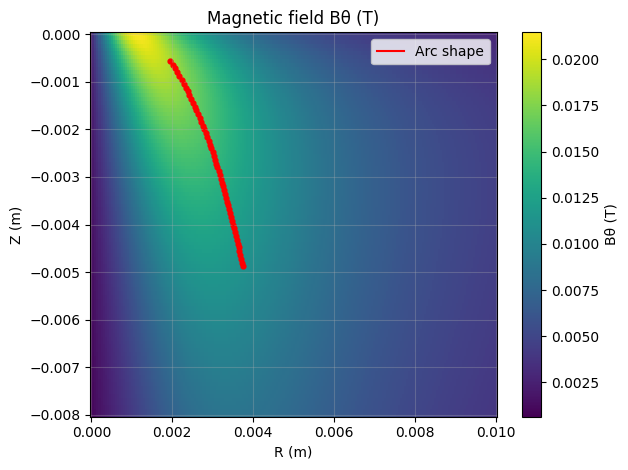

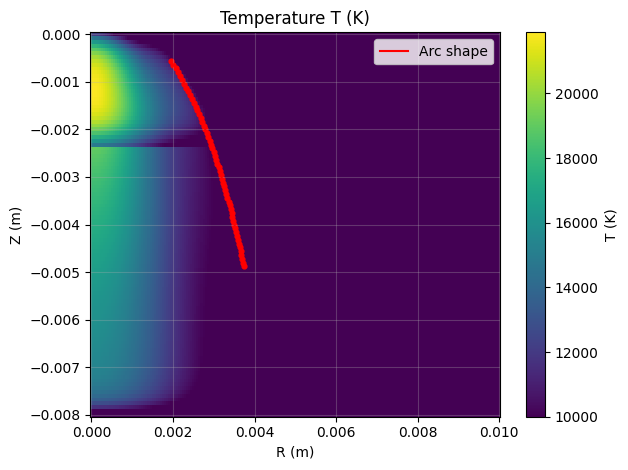

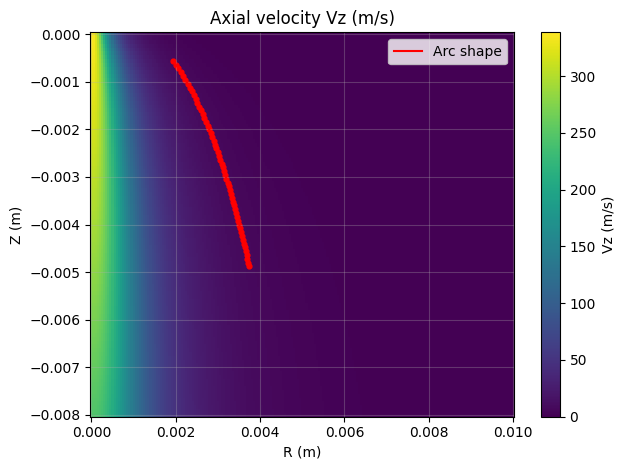

In [49]:
pseudocolor.plot_arccolumn_isolines(arc_column, Zcoord, Ra_filtered)

Additionally, fifteen normalized radial profiles at different axial positions are shown for each characteristic. Each axial position is represented by a different color. The plots also show a vertical line at the arc radius location, calculated by deducing that, if $R = R_a$, then for the magnetic field:

$$
\boxed{x(R = R_a) = \frac{R}{R_a}\mathrm{Pr}^{-1} = \frac{R_a}{R_a}\mathrm{Pr}^{-1} = Pr^{-0.5}}
$$

and for the temperature and the axial velocity:

$$
\boxed{x(R = R_a) = \frac{R}{R_a}\mathrm{Pr}^{-1} = \frac{R_a}{R_a}\mathrm{Pr}^{-1} = Pr^{-1}}
$$

Arc radius at the magnetic field profile: x = 1.306
Arc radius at the temperature and velocity profiles: x = 1.706


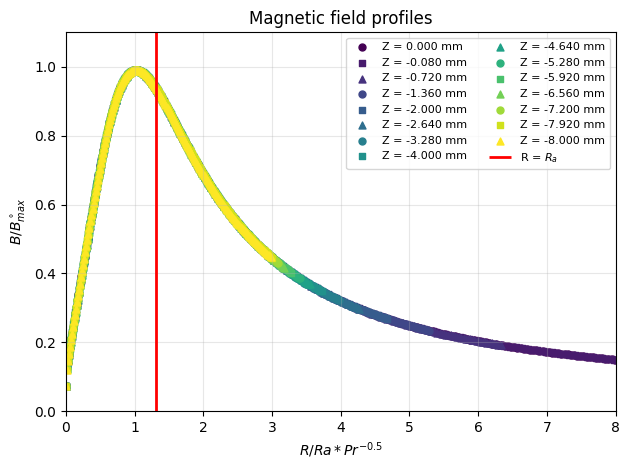

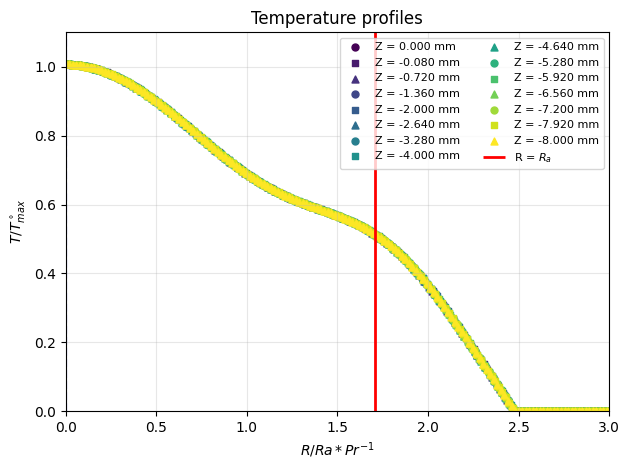

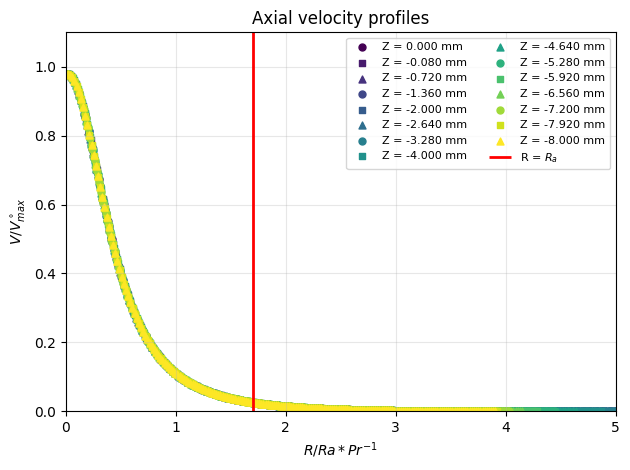

In [50]:
print(f"Arc radius at the magnetic field profile: x = {(1/Pr_number**0.5):.3f}")
print(f"Arc radius at the temperature and velocity profiles: x = {(1/Pr_number):.3f}")
plotlib.plot_normalized_profiles(arc_column, Pr_number)

### Discussion

A very important consideration to be mentioned is that the equation 4 shown in Delgado-Álvarez et. al. (2021) [[1](#ref-1)] restricts the validity range of the temperature profile to $\frac{R}{R_a}\mathrm{Pr}^{-1} ≤ 1 $. Every temperature value calculated outside this range of validity can't be interpreted as correct. For the shielding gas with 100% Argon or the mixture 50/50 with Helium, the range of validity does not cover the whole arc column, as the Prandtl number $Pr < 1$ for both cases. For 100% Helium, the arc column is fully covered in this validity range. Neither the magnetic field nor the axial velocity normalized profiles are restricted to a specific range of validity.

However, the output of this equation does not look like the ones of the **Figure 5b** [[1](#ref-1)] for any of the three gas compositions. Also, when plotting the pseudocolor diagram for 100% Ar, the isotherm of 10,000 K and the arc shape do not have the same position. The cause of this problem could not be determined, so it was decided to implement the equation 4 [[2](#ref-2)] which only works for 100% Argon. With this equation, the 10,000 K isotherm fits the arc shape, and the temperature profile is similar to the **Figure 5b** [[1](#ref-1)].

For Helium or Argon/Helium, no alternative equation is available at the bibliography. Understanding the reason why this equation shows such a result, is an opportunity to improve the algorithm.

The magnetic field increases linearly as the radial position increases inside the arc, reaching a maximum at the arc radius. At larger radial positions, the magnetic field has an asymptotic inverse relationship to the radial coordinate, in accordance with Ampere’s law. (Delgado-Álvarez et. al., 2021) [[1](#ref-1)]. 

The axial velocity is maximum at the symmetry axis, and decreases following a Gaussian bell. Outside the arc radius, the velocity tends to zero. This can be seen at the velocity profiles, and also at the heatmap. The maximum velocity gets reduced along the axial axis, but this reduction is not significant.

The **Table 5** [[1](#ref-1)] specifies that the local maxima at specific axial distance for the magnetic field and the axial velocity have their range between $0.4 < Z/L < 0.8$. By setting `valid_arc_column = True` or `False`, this validity range can be applied and visualize only those values calculated between those boundaries.

The **Table 2** shows that the local maxima of the temperature must be calculated in two intervals: the first one $0.0 < Z/L < 0.3$, and the second one $0.3 ≤ Z/L < 1.0$. This causes a hard switch in the pseudocolor plot, visible at $Z/L = 0.3$.

Finally, the Prandtl number affects the way the heat is transferred. When $Pr > 1$, as in the case of Helium, the momentum diffuses faster than the heat, so the temperature gradients outside of the arc column are larger. In the case of the Argon, for a $Pr < 1$, the temperature gradients inside the arc column are large, spreading quick, and the momentum diffuses slower than the heat.

## Arc - weld pool interactions

The interactions between the arc and the weld-pool determine the geometry of the bead and fusion zone, and can be used by practitioners to understand and troubleshoot welding procedures, and modelers as boundary conditions in their simulations [[1](#ref-1)]. These arc characteristics take place only at the section where the arc makes contact with the anode, i.e. at $Z = L$. 

These characteristics are:
- Arc pressure
- Heat flux
- Current density
- Shear stress (only for pure Argon shielding gas)

### Computing the interactions

The arc - weld pool interactions are also computed in the `processing` module, the same way as the arc column characteristics. The selection of the coefficients and the application of the equations is processed internally. 

To compute these interactions, the radial axis $(R)$ is redefined to avoid calculating $ln(R = 0)$ at the Shear Stress, and also because the already existant radial axis was too short, as at the cathode the profiles are much larger than along the arc column. The new axis definition is a discrete variable of 100 elements, starting at $R_0 = 1*10^{-10}\,m$ until $R_1 = 15\,mm$.

The `acm4tw` module computes the arc - weld pool interactions using the following equations:

The heat flux $q/q_{max}$:

$$
\frac{q}{q_{\max}}\,(R) = \frac{a +
b \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.2}} \right)^2 +
c \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.2}} \right)^4 +
d \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.2}} \right)^6}
{1 + e \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.2}} \right)^2 +
f \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.2}} \right)^4 +
g \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.2}} \right)^6}
$$

The current density $J/J_{max}$:

$$
\frac{J}{J_{\max}}\,(R) = \frac{a +
b \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.3}} \right)^2 +
c \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.3}} \right)^4 +
d \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.3}} \right)^6}
{1 + e \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.3}} \right)^2 +
f \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.3}} \right)^4 +
g \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.3}} \right)^6 +
h \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.3}} \right)^8}
$$

The pressure $P/P_{max}$:

$$
\frac{P}{P_{\max}}\,(R) = \frac{a +
b \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.8}} \right)^2 +
c \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.8}} \right)^4 +
d \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.8}} \right)^6 +}
{1 + e \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.8}} \right)^2 +
f \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.8}} \right)^4 +
g \left( \dfrac{R}{(R_a L)^{0.5}\mathrm{Pr}^{0.8}} \right)^6}
$$

The shear stress $\tau/\tau_{max}$ (for 100% Ar only):

$$
\frac{\tau}{\tau_{\max}}\,(R) = \frac{a +
b \ln\left( \dfrac{R}{(R_a L)^{0.5}} \right) +
c \left[ \ln\left( \dfrac{R}{(R_a L)^{0.5}} \right) \right]^2}
{1 + d \ln\left( \dfrac{R}{(R_a L)^{0.5}} \right) +
e \left[ \ln\left( \dfrac{R}{(R_a L)^{0.5}} \right) \right]^2}
$$

The maximum heat flux $q_{max}$, current density $J_{max}$ or pressure $P_{max}$:

$$
\mathrm{Interaction}_{\max} = \exp\left( a + b I + c L \right)
$$

The maximum shear stress $\tau_{max}$ (for 100% Ar only):

$$
\mathrm{\tau}_{\max} = a + b L + c I
$$

where:
- $R_a$ is the arc radius at $Z=L$
- $Pr$ is the Prandtl number
- $L$ is the arc length
- $I$ is the current intensity
- $a$, $b$, $c$, $d$, $e$, $f$ and $g$ are constants obtained from the **Table 5** (or **Table 2** for the shear stress)

The results are given in the `interactions` Python dictionary. Additionally, the maximum for each interaction is given in SI units.

In [51]:
interactions = processing.arc_weld_pool_interactions(current, arclength, gas_name, Pr_number, Ra, table2, table5)

Maximum heat density: q_max = 6.294e+04 kW/m^2
Maximum current density: J_max = 5.567e+03 kA/m^2
Maximum arc pressure: P_max = 0.792 kPa
Maximum shear stress: tau_max = -1.136e+03 kPa


### Plotting

All the arc - weld pool interaction profiles, including both the normalized ones and their absolute quantities, have been previously stored in the `interactions` dictionary. However, in this Jupyter Notebook only the normalized ones are presented, using the `plotlib` module. The absolute profiles, calculated from the local maxima of each interaction, could be shown by very simple modifications of the algorithms using here.

The radial dimensionless coordinate is represented in this case using not only the arc radius and the Prandtl number, but also the arc length $L$, since all the interactions increase as the arc becomes shorter [[1](#ref-1)].

Similarly as with the arc column characteristics, the arc radius is shown as a red vertical line. Its position along the normalized X-axis is deduced as it follows: if $R = R_a$, then, for the Heat Flux ($q/q_{max}$):

$$
\boxed{x_q(R = R_a) = \frac{R}{R_a^{0.5}L^{0.5}}\mathrm{Pr}^{0.2} = \frac{R_a}{R_a^{0.5}L^{0.5}}\mathrm{Pr}^{0.2} = \left(\frac{R_a}{L}\right)^{0.5}\mathrm{Pr}^{0.2}}
$$

for the Current Density ($J/J_{max}$):

$$
\boxed{x_J(R = R_a) = \frac{R}{R_a^{0.5}L^{0.5}}\mathrm{Pr}^{0.3} = \frac{R_a}{R_a^{0.5}L^{0.5}}\mathrm{Pr}^{0.3} = \left(\frac{R_a}{L}\right)^{0.5}\mathrm{Pr}^{0.3}}
$$

for the Pressure ($P/P_{max}$):

$$
\boxed{x_P(R = R_a) = \frac{R}{R_a^{0.5}L^{0.5}}\mathrm{Pr}^{0.8} = \frac{R_a}{R_a^{0.5}L^{0.5}}\mathrm{Pr}^{0.8} = \left(\frac{R_a}{L}\right)^{0.5}\mathrm{Pr}^{0.8}}
$$

for the Shear Stress ($\tau/\tau_{max}$):

$$
\boxed{x_{\tau}(R = R_a) = \frac{R}{R_a^{0.5}L^{0.5}} = \frac{R_a}{R_a^{0.5}L^{0.5}} = \left(\frac{R_a}{L}\right)^{0.5}}
$$

with $R_a$ being the *arc radius* at *Z = L*, $L$ the *arc length* and $Pr$ the *Prandtl Number*

> ##### Model limitation
>
> If the welding under analysis was set with pure Helium or with its mixture with Argon as shielding gas, **the shear stress will not be shown in this section.**

X coordinate of the Heat flux profile: 0.664
X coordinate of the Current density profile: 0.629
X coordinate of the Arc pressure profile: 0.482
X coordinate of the Shear stress profile: 0.739


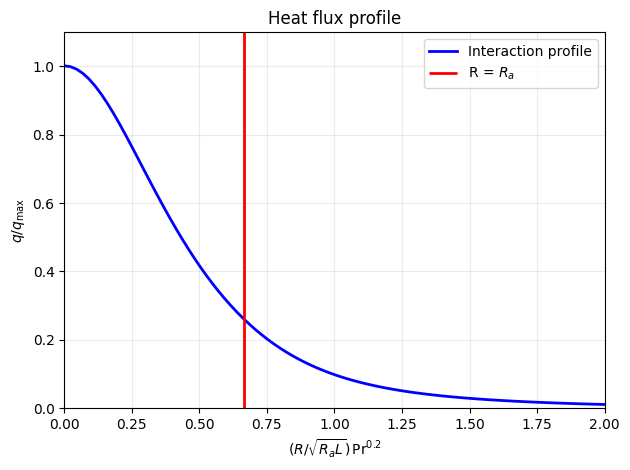

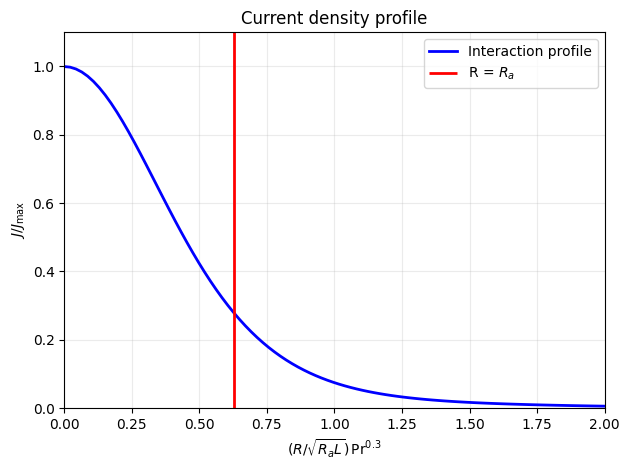

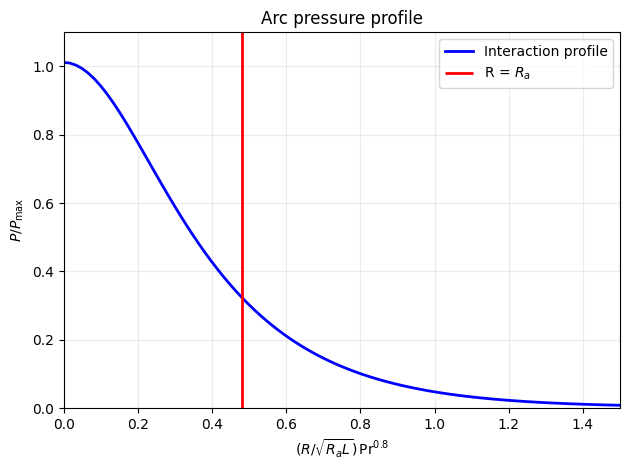

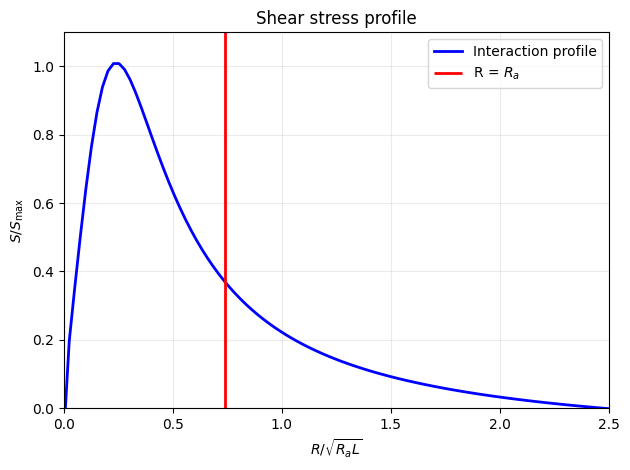

In [52]:
plotlib.plot_heat(interactions["xi_q"], interactions["q_norm"], Ra, arclength, Pr_number)
plotlib.plot_current(interactions["xi_J"], interactions["J_norm"], Ra, arclength, Pr_number)
plotlib.plot_pressure(interactions["xi_P"], interactions["P_norm"], Ra, arclength, Pr_number)
if gas_name == "Argon":
    plotlib.plot_shear(interactions["xi_S"], interactions["S_norm"], Ra, arclength, Pr_number)

### Discussion

When comparing the arc–weld-pool interaction profiles of the measurements obtained with argon to those obtained with helium, the shape is the same for both gases because it has been normalized using the Prandtl number. However, when plotting the red vertical line representing the arc radius at the anode, the heat flux, current density, and arc pressure are higher at $R = R_a$ when welding with argon than with helium. This model shows that a 100% Ar shielding gas has a greater influence on the shape of the weld pool.

Universal dimensionless radial profiles of heat and current fluxes as well as arc pressure exhibit a Gaussian-like shape as a result of the gas jet impingement on the weld pool (Delgado-Álvarez, et. al. 2021) [[1](#ref-1)]. These profiles are maximum at the stagnation point, at the symmetry axis. The shear stress at the anode shows a more complex behavior, which can be explained by the boundary layer formed when the plasma jet impinges on the workpiece. While the arc pressure shows a maximum, the shear stress at the stagnation point is zero. When the plasma propagates in a radial direction, the velocity and the shear stress reach a maximum. Both interactions decrease when the plasma loses momentum in the radial coordinate (Villarreal-Medina, et. al. 2023) [[3](#ref-3)].


## Conclusions

This Jupyter Notebook has replicated the workflow shown in Delgado-Álvarez et al. (2021) [[1](#ref-1)] and can now be applied with custom boundary conditions to simulate the arc characteristics of a specific TIG welding process.

During the development of this model, I:
- learned how to adapt the equations of a scientific publication and use them for the intended purpose,
- understood what the Prandtl number is and how it affects the plasma,
- evaluated the modeled arc characteristics by comparing them with the results presented in [[1](#ref-1)],
- defined the data structure for each variable and organized the results accordingly,
- acknowledged the limitations of the model and documented them appropriately.

The **Equation 4** [[1](#ref-1)] of the normalized temperature profile for monoatomic gases did not produce a result similar to the one shown in Delgado-Álvarez et al. (2021). Every step was revised several times, and even so, I could not identify the cause of this behaviour. Therefore, I decided to use the different **Equation 4** [[2](#ref-2)], with the limitation that the temperature profile can now only be calculated for 100% argon. For other gas compositions, the previous equation is the only one available, and the resulting profile may not be entirely accurate.

One opportunity to improve the model concerns the equation for the shear stress at the anode, which could be further developed to allow its estimation for helium or argon/helium mixtures. Another useful extension would be to enable gas mixtures with custom compositions, for example, 70% Ar and 30% He. Finally, as mentioned in [[1](#ref-1)], modeling the influence of metallic vapor on the plasma would be a very promising approach and would certainly provide a more realistic estimation of the arc characteristics.

## References

1. <a id="ref-1"></a> Delgado-Álvarez, A., Méndez, P. F., Murphy, A. B., & Ramírez-Argáez, M. A. (2021). Generalized representation of arc shape, arc column characteristics and arc–weld pool interactions for DC electric arcs burning in monoatomic gases. *Journal of Physics D: Applied Physics, 54*(5), 055001. https://doi.org/10.1088/1361-6463/abbfc7

2. <a id="ref-2"></a> Delgado-Álvarez, A., Méndez, P. F., & Ramírez-Argáez, M. A. (2019). Dimensionless representation of the column characteristics and weld pool interactions for a DC argon arc. *Science and Technology of Welding and Joining, 24*(7), 634–643. https://doi.org/10.1080/13621718.2019.1584455

3. <a id="ref-3"></a> Villarreal-Medina, R., Delgado-Álvarez, A., Murphy, A. B., Méndez, P. F., & Ramírez-Argáez, M. A. (2023). General expressions for heat distribution, pressure, and current density in argon welding arcs. *IOP Conference Series: Materials Science and Engineering, 1281*(1), 012007. https://doi.org/10.1088/1757-899X/1281/1/012007